# 주가지수만들기
--------------
<STEP 1>
   1. TCI 지수 선정 : 일일 확진자(과거데이터 가중치{EMA,MA등 사용}, 거리두기 단계(1~4단계), Additional Wieghted_Value : 누적사망자/누적확진자)
   > (누적사망자/누적확진자) 가 클수록 코로나의 위험도가 증가한다고 판단하여 가중치 값으로 선정
   2. TCI 지수와 코스피, 코스닥 움직임 상관관계 예측
---------------
<STEP 2>
   1. TCI 지수 산출을 위한 데이터 만들기 ('2020.03.10' ~ '2022.02.28')
   > 지수 산출방법 : ```(추가로더적을 부분)``` 4번까지 한다음에 다시 피드백해서 정하기
   2. 코스피, 코스닥 동기간 종가 불러오기
   3. 임의로 만든 TCI와 KOSPI & KOSDAQ 상관관계 비교
   4. 산업군별로 데이터분석
      > 상관성 높은 산업군에서 예측모델 사용권장
      ``예측은 아마도 헬스케어는 + , 운송업은 -``

In [35]:
import FinanceDataReader as fdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

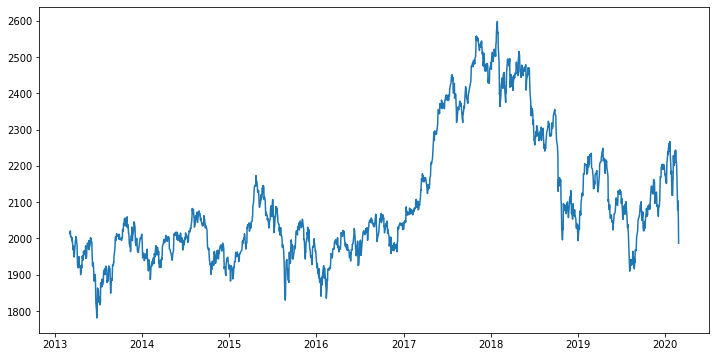

In [36]:
# kospi_df 만들고 시각화 해보기(2013~2020)
Kospi_df = fdr.DataReader('KS11', '2013-03-01', '2020-02-29')
plt.figure(figsize=(12,6), facecolor='w')
plt.plot(Kospi_df['Close'])
Kospi_c = Kospi_df['Close']
Kospi_df_c = pd.DataFrame(Kospi_c)

In [37]:
# 비교군 데이터 생성
Kospi_df_last10day = fdr.DataReader('KS11', '2020-02-24', '2020-03-7')
Kospi_last10day_c =  Kospi_df_last10day['Close']
Kospi_df_last10day_c = pd.DataFrame(Kospi_last10day_c)
Kospi_df_last10day_c

,Close
Date,
2020-02-24,2079.04
2020-02-25,2103.61
2020-02-26,2076.77
2020-02-27,2054.89
2020-02-28,1987.01
2020-03-02,2002.51
2020-03-03,2014.15
2020-03-04,2059.33
2020-03-05,2085.26


In [38]:
# ARIMA Model 적용
model = ARIMA(Kospi_df_c,order = (2,0,0))
model_fit = model.fit()
forecast_data = model_fit.forecast(steps=5) # 마지막 5일의 예측 데이터 
# pred_arima = forecast_data.tolist()   
# Kospi_df_c.append(pred_arima)

In [26]:
forecast_data

1719    1985.427275
1720    1985.937780
1721    1986.511673
1722    1987.084794
1723    1987.655128
Name: predicted_mean, dtype: float64

In [39]:
# Arima 모델을 이용해 예측한 값과 실제 값 비교해보기
Kospi_df_last10day_c['Pred'] = Kospi_df_last10day_c['Close']
Kospi_df_last10day_c['Pred'][5:] = forecast_data.round(2)
Kospi_df_last10day_c

,Close,Pred
Date,,
2020-02-24,2079.04,2079.04
2020-02-25,2103.61,2103.61
2020-02-26,2076.77,2076.77
2020-02-27,2054.89,2054.89
2020-02-28,1987.01,1987.01
2020-03-02,2002.51,1985.43
2020-03-03,2014.15,1985.94
2020-03-04,2059.33,1986.51
2020-03-05,2085.26,1987.08


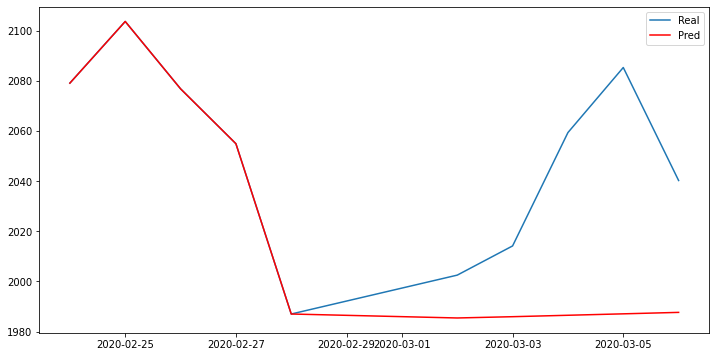

In [34]:
# 실제값과 예측값 그래프 비교
plt.figure(figsize=(12,6), facecolor='w')
plt.plot(Kospi_df_last10day_c['Close'], label = 'Real')
plt.plot(Kospi_df_last10day_c['Pred'], color = 'r', label = 'Pred')
plt.legend()

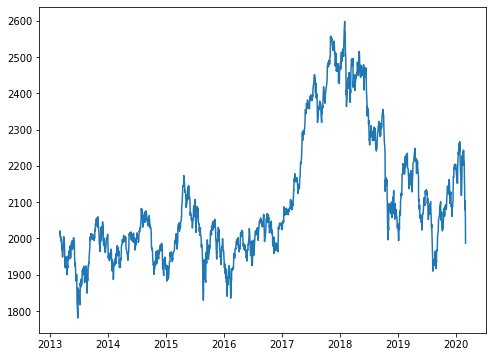

In [35]:
y_train = Kospi_df['Close'][:int(0.7*len(Kospi_df['Close']))]
y_test = Kospi_df['Close'][int(0.7*len(Kospi_df['Close'])):]

In [16]:
kpss_diffs = ndiffs(Kospi_df['Close'], alpha=0.05, test='kpss', max_d= 6)
adf_diffs = ndiffs(Kospi_df['Close'], alpha=0.05, test='adf', max_d=6)
n_diffs = max(kpss_diffs,adf_diffs)

print(f'적정 차분 차수는 {n_diffs}')

적정 차분 차수는 1


In [19]:
model = pm.auto_arima(y=Kospi_df['Close'], d=1, start_p=0, max_p=3, start_q=0, max_q=3, seasonal=False, stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14485.143, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14485.680, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14485.852, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14483.145, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=14484.680, Time=0.43 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.001 seconds


In [22]:
def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)

    return(fc.tolist()[0], np.asarray(conf_int).tolist()[0])

In [23]:
forecast_one_step()

(1987.01, [1954.920622519133, 2019.099377480867])

In [25]:
forecast_list=[]
pred=[]
pred_upper=[]
pred_lower=[]

for i in Kospi_df['Close']:
    fc, conf = forecast_one_step()
    pred.append(fc)
    pred_upper.append(conf[1])
    pred_lower.append(conf[0])

    model.update(i)

In [28]:
pred_df = pd.DataFrame({'real' : Kospi_df['Close'], 'pred' : pred})

DatetimeIndex(['2013-03-04', '2013-03-05', '2013-03-06', '2013-03-07',
               '2013-03-08', '2013-03-11', '2013-03-12', '2013-03-13',
               '2013-03-14', '2013-03-15',
               ...
               '2020-02-17', '2020-02-18', '2020-02-19', '2020-02-20',
               '2020-02-21', '2020-02-24', '2020-02-25', '2020-02-26',
               '2020-02-27', '2020-02-28'],
              dtype='datetime64[ns]', name='Date', length=1719, freq=None)

In [36]:
kpss_diffs = ndiffs(y_train, alpha=0.05, test='kpss', max_d= 6)
adf_diffs = ndiffs(y_train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(kpss_diffs,adf_diffs)

print(f'적정 차분 차수는 {n_diffs}')

적정 차분 차수는 1


In [37]:
model = pm.auto_arima(y=y_train, d=1, start_p=0, max_p=3, start_q=0, max_q=3, seasonal=False, stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9844.130, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9844.715, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9844.686, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9843.147, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9846.656, Time=0.42 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.729 seconds


In [38]:
def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)

    return(fc.tolist()[0], np.asarray(conf_int).tolist()[0])

In [39]:
forecast_one_step()

(2520.26, [2491.8242819195625, 2548.695718080438])

In [40]:
forecast_list=[]
y_pred=[]
pred_upper=[]
pred_lower=[]

for i in y_test:
    fc, conf = forecast_one_step()
    y_pred.append(fc)
    pred_upper.append(conf[1])
    pred_lower.append(conf[0])

    model.update(i)

In [41]:
pd.DataFrame({'test':y_test,'pred':y_pred})

,test,pred
Date,,
2018-01-22,2502.11,2520.26
2018-01-23,2536.60,2502.11
2018-01-24,2538.00,2536.60
2018-01-25,2562.23,2538.00
2018-01-26,2574.76,2562.23
...,...,...
2020-02-24,2079.04,2162.84
2020-02-25,2103.61,2079.04
2020-02-26,2076.77,2103.61


In [42]:
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "notebook_connected"

fig = go.Figure([
    go.Scatter(x=y_train.index, y=y_train, name='Train', mode='lines', line=dict(color='pink'))
    ,go.Scatter(x=y_test.index, y=y_test, name='Test', mode='lines', line=dict(color='purple'))
    ,go.Scatter(x=y_test.index, y=y_pred, name='Pred', mode='lines', line=dict(color='yellow',dash='dot',width=3))
    ,go.Scatter(x=y_test.index.tolist() + y_test.index[::-1].tolist(), y=pred_upper + pred_lower[::-1], fillcolor='rgba(0,0,30,0.1)',line={'color':'rgba(0,0,0,0)'},
    hoverinfo="skip",showlegend=True)
])

fig.update_layout(height=400, width=1000, title_text="ARIMA(0,1,0)")
fig.show()

# 국가간 특정 지수별 상관관계찾기

In [1]:
import FinanceDataReader as fdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import arima
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [2]:
# kospi, kodaq, dow, nasdaq, s&p500 지수 가지고 오기
Kospi_df = fdr.DataReader('KS11', '2012-04-01', '2022-04-01')
Kodaq_df = fdr.DataReader('KQ11', '2012-04-01', '2022-04-01')
Dow_df = fdr.DataReader('DJI', '2012-04-01', '2022-04-01')
Nasdaq_df = fdr.DataReader('IXIC', '2012-04-01', '2022-04-01')
Snp500_df = fdr.DataReader('US500', '2012-04-01', '2022-04-01')


In [3]:
# 분석에 필요한 지수별 종가만 데이터프레임으로 만들기
df_all = pd.DataFrame()
df_name = ['Kospi', 'Kodaq']
df_name_dt = [Kospi_df, Kodaq_df]
df_list = ['Dow', 'Nasdaq', 'Snp500']
df_list_dt = [Dow_df, Nasdaq_df, Snp500_df]
for j, name_ in enumerate(df_name_dt):
    for i, col in enumerate(df_list):
        df_INNER_JOIN = pd.merge(name_['Close'], df_list_dt[i]['Close'], left_on=name_.index, right_on=df_list_dt[i].index , how='inner')
        df_INNER_JOIN.columns = ['DATE', df_name[j], col]
        df_all[['DATE', df_name[j], col]] = df_INNER_JOIN[['DATE', df_name[j], col]]
df_all

,DATE,Kospi,Dow,Nasdaq,Snp500,Kodaq
0,2012-04-02,2029.29,13264.49,3119.70,1419.04,521.80
1,2012-04-03,2049.28,13199.55,3113.57,1413.38,515.83
2,2012-04-04,2018.61,13074.75,3068.09,1398.96,502.97
3,2012-04-05,2028.77,13060.14,3080.50,1398.08,503.34
4,2012-04-09,1997.08,12929.59,3047.08,1382.20,486.80
...,...,...,...,...,...,...
2383,2022-03-25,2729.56,34861.70,14169.30,4543.04,934.69
2384,2022-03-28,2741.07,34955.23,14354.90,4575.52,927.11
2385,2022-03-29,2746.74,35295.11,14619.64,4631.60,937.83
2386,2022-03-30,2757.65,35228.15,14442.28,4602.45,939.07


In [4]:
# 회귀 모델과 스코어링 모델 import 하기
import reg_model
import score_model
from imp import reload
reload(reg_model)
reload(score_model)

<module 'score_model' from 'c:\\Users\\kht91\\Desktop\\유비온\\해커톤_cococo\\score_model.py'>

In [5]:
# 회귀 모델과 스코어링 모델 선언
rg = reg_model.RegALL()
sm = score_model.ScoreALL()

In [6]:
# train/test 나누기
X_train, X_test, y_train, y_test = train_test_split(df_all.drop(['DATE','Kospi','Kodaq'],axis=1), df_all['Kospi'], test_size=0.3, random_state=0)

In [7]:
# 회귀 적용
pred_linr=rg.Linreg(X_train, X_test, y_train)
pred_logr=rg.Logreg(X_train, X_test, y_train)
pred_rid=rg.Rid(X_train, X_test, y_train)
pred_las=rg.Las(X_train, X_test, y_train)

# 스코어링을 위한 리스트 만들기
pred_list_name = ['pred_linr', 'pred_logr', 'pred_rid', 'pred_las']
pred_list_df = [pred_linr, pred_logr, pred_rid, pred_las]

# 선형회귀에 적용되는 스코어링 적용해보기
for i, target in enumerate(pred_list_df):
    print("\n",pred_list_name[i])
    sm.r2_(y_test,target)
    sm.evs_(y_test,target)


 pred_linr
r2_score : 0.7836
explained_variance_score : 0.7836

 pred_logr
r2_score : 0.6365
explained_variance_score : 0.6578

 pred_rid
r2_score : 0.7836
explained_variance_score : 0.7836

 pred_las
r2_score : 0.7836
explained_variance_score : 0.7836
